In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [ ]:
from scipy.stats import entropy

In [3]:
# Initialize the GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")


In [108]:
import numpy as np
from matplotlib.colors import LogNorm


In [188]:
tokenizer.vocab_size


50257

Entropy: 4.2780684402123645


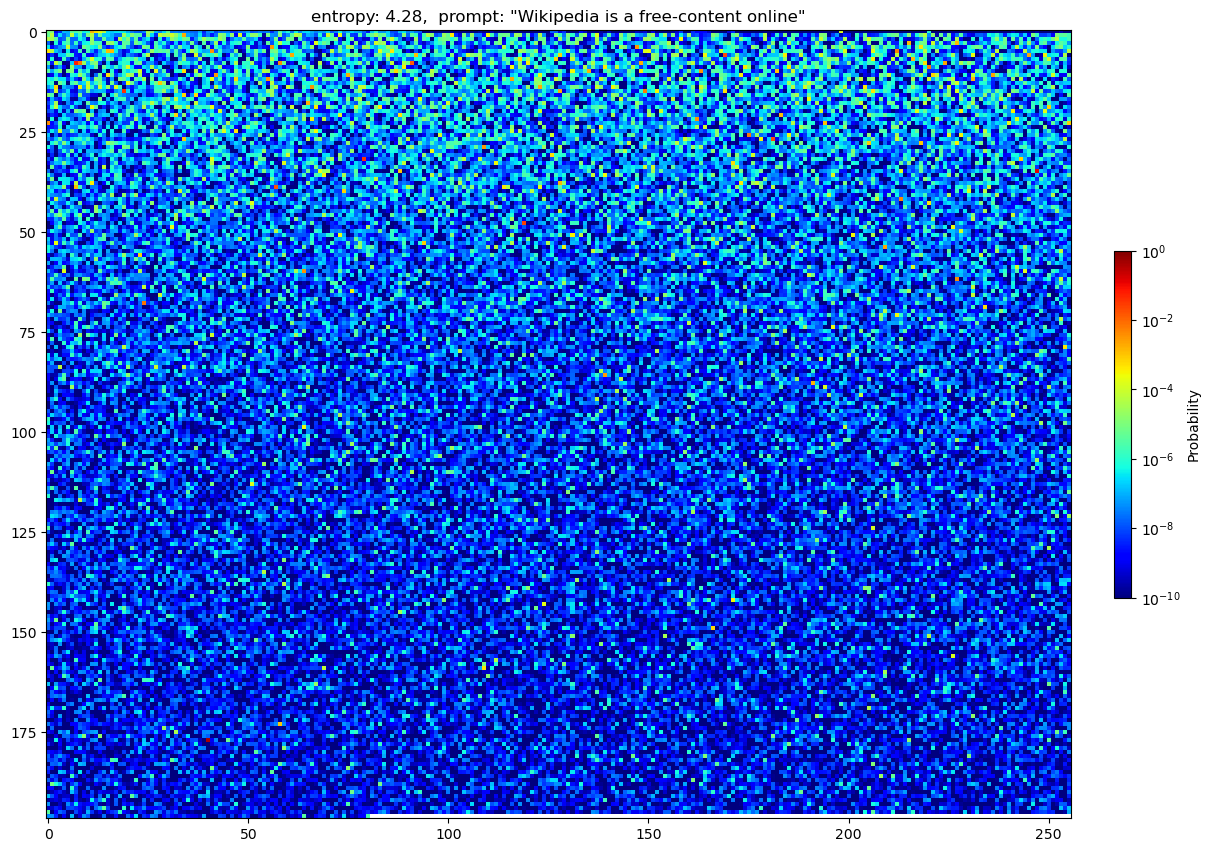

In [185]:
text = "Wikipedia is a free-content online"

inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits[:, -1, :]  # Taking the logits corresponding to the last token in input
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

probabilities_np = probabilities.numpy().flatten()
# Padding zeros to fit the grid size
probabilities_np = np.concatenate((probabilities_np, np.zeros(256 * 197 - tokenizer.vocab_size)))

# Reshape the array
reshaped_probs = probabilities_np.reshape((197, 256))

# Create the heatmap
plt.figure(figsize=(14, 12))
im = plt.imshow(reshaped_probs, cmap="jet", interpolation="nearest", norm=LogNorm(vmin=1e-10, vmax=1))

# Create the colorbar
cbar = plt.colorbar(im, label="Probability", fraction=0.016, pad=0.04)
cbar.ax.set_yscale('log')

# plt.title("Heatmap of Output Probabilities (Log Scale)")

# Using scipy.stats.entropy function, and converting tensor to numpy array
output_entropy = entropy(probabilities.numpy().flatten(), base=2)
print(f"Entropy: {output_entropy}")


plt.title(f'entropy: {output_entropy:.2f},  prompt: "{text}"')
plt.show()


Entropy: 9.035131264787566


In [195]:
# Define a text prompt
# prompt = "The sky is"
prompt = "XXX"
# Tokenize the prompt and generate output IDs and logits
input_ids = tokenizer.encode(prompt, return_tensors="pt")
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits

# Get logits corresponding to the last token (prediction)
last_logits = logits[0, -1, :]

# Apply softmax to get probabilities
import torch.nn.functional as F
probabilities = F.softmax(last_logits, dim=-1)

# Optionally, you can sort and get top-k tokens
sorted_indices = torch.argsort(probabilities, descending=True)
top_k = 10
for i in range(top_k):
    token_id = sorted_indices[i].item()
    token = tokenizer.decode([token_id])
    probability = probabilities[token_id].item()
    print(f"Token: {token}, Probability: {probability}")

Token: ., Probability: 0.056804358959198
Token: 
, Probability: 0.04573997110128403
Token: ,, Probability: 0.0419611930847168
Token: -, Probability: 0.01941790245473385
Token:  and, Probability: 0.014107235707342625
Token: :, Probability: 0.013567053712904453
Token:  (, Probability: 0.011976217851042747
Token:  of, Probability: 0.008427382446825504
Token:  is, Probability: 0.008177888579666615
Token: ), Probability: 0.007464623544365168


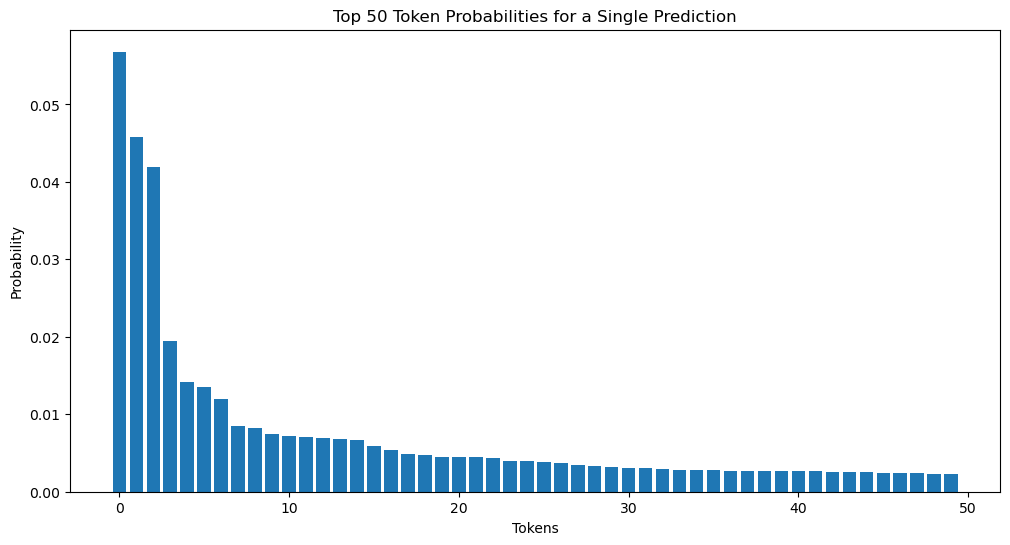

In [196]:
top_n = 50
top_probs, top_indices = torch.topk(probabilities, top_n)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), top_probs)
plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Top 50 Token Probabilities for a Single Prediction')
plt.show()

In [57]:

def generate_and_record_probs(tokenizer, model, prompt, num_generate=5, print_tokens=False,  temperature=1.0, top_k=None):
    # Initialize list to store all top 50 probabilities for each token
    all_top_probs = []
    
    # Convert prompt to input_ids
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    for i in range(num_generate):
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
            last_logits = logits[0, -1, :]
            probabilities = F.softmax(last_logits, dim=-1)
            
            # Store the top 50 probabilities
            top_probs, top_indices = torch.topk(probabilities, 50)
            all_top_probs.append(top_probs)
            
            # Get most probable token and its probability
            most_probable_token_id = top_indices[0].item()
            most_probable_token = tokenizer.decode([most_probable_token_id])
            most_probable_token_prob = top_probs[0].item()
            
            # Generate the next token and append to input_ids
            logits = last_logits / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[ [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)

            next_token = torch.multinomial(probs, 1)
            next_token_id = next_token.item()
            next_token_str = tokenizer.decode([next_token_id])
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
            
            if print_tokens:
                # print(f"Top: {most_probable_token}, p: {most_probable_token_prob:.4f}, selected: {next_token_str}, p: {probabilities[next_token_id].item():.4f}")
                field_width = 10

                print(f"i = {i:<{3}} Top: {most_probable_token:<{field_width}} p: {most_probable_token_prob:.4f} "
                    f"Selected: {next_token_str:<{field_width}} p: {probabilities[next_token_id].item():.4f}")

    generated_text = tokenizer.decode(input_ids.squeeze(), skip_special_tokens=True)         
    return all_top_probs, generated_text




In [186]:
# Example usage
prompt = "Wikipedia is a free-content online"
all_top_probs, generated_text = generate_and_record_probs(tokenizer, model, prompt,num_generate = 20, print_tokens=True, temperature=1.0)
print(generated_text)



i = 0   Top:  encyclopedia p: 0.4247 Selected:  encyclopedia p: 0.4247
i = 1   Top: .          p: 0.2845 Selected:  created   p: 0.0066
i = 2   Top:  by        p: 0.6547 Selected:  to        p: 0.1121
i = 3   Top:  provide   p: 0.1311 Selected:  enhance   p: 0.0095
i = 4   Top:  the       p: 0.2871 Selected:  understanding p: 0.0679
i = 5   Top:  of        p: 0.6798 Selected:  of        p: 0.6798
i = 6   Top:  the       p: 0.2078 Selected:  Ethics    p: 0.0000
i = 7   Top:  and       p: 0.3318 Selected: ,          p: 0.2083
i = 8   Top:  Ethics    p: 0.1022 Selected:  Consumer  p: 0.0003
i = 9   Top: ism        p: 0.2268 Selected: ism        p: 0.2268
i = 10  Top: ,          p: 0.7685 Selected: ,          p: 0.7685
i = 11  Top:  and       p: 0.4237 Selected:  Sexual    p: 0.0011
i = 12  Top: ity        p: 0.7244 Selected: ity        p: 0.7244
i = 13  Top: ,          p: 0.6967 Selected: ,          p: 0.6967
i = 14  Top:  and       p: 0.3519 Selected:  Social    p: 0.0073
i = 15  Top:  J

/tmp/ipykernel_125788/3697905157.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(all_top_probs))


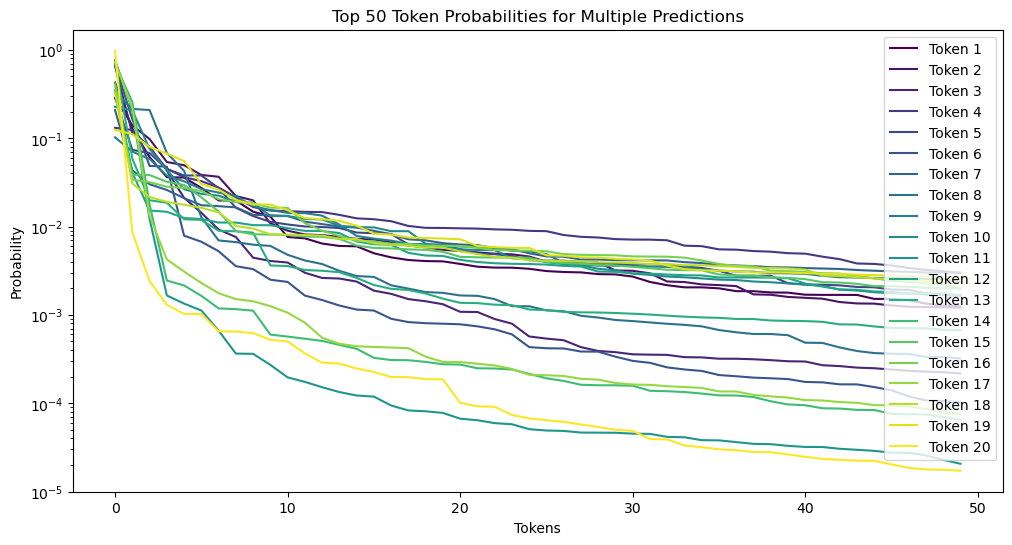

In [187]:
import matplotlib.cm as cm

# Plotting
plt.figure(figsize=(12, 6))

# Create a colormap
colormap = cm.get_cmap('viridis', len(all_top_probs))

for i, top_probs in enumerate(all_top_probs):
    color = colormap(i)
    plt.plot(range(50), top_probs.numpy(), label=f'Token {i+1}', color=color)

plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Top 50 Token Probabilities for Multiple Predictions')
plt.legend()
# plt.colorbar(cm.ScalarMappable(cmap=colormap), label='Token Index')

plt.yscale('log')

plt.show()
